# Intel Image Classififcation

#### The given dataset has different types of categorys as below

1. Buildings
2. Forest
3. Glacier
4. Mountain
5. Sea
6. Street

For each categorys, it has individual set of images, for to train and the test model. Most of the images are in 150 x 150 pixle size and some where in improper size format. So, all the images will be resized to 100 x 100.


#### Below are the steps i had followed for to train & test the model.

1. Import the necesasary libraties and image files
2. Create a Linear SVM model and train it
3. Check the accuracy score of the model
4. Predict some random images
5. Improve the model using PCA

### 1. Imports

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm
import random as rn
from random import shuffle  
from zipfile import ZipFile
from PIL import Image
from skimage import feature, color, data
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.svm import LinearSVC
import warnings
warnings.filterwarnings('ignore')
from sklearn import metrics
import seaborn as sn;sn.set(font_scale=1.4)

### 2. Paths

In [9]:
CURR_DIR_PATH = os.getcwd()

# Training paths
seg_train_path = CURR_DIR_PATH + "//data//seg_train//seg_train"

train_forest_path = seg_train_path + "//forest"
train_buildings_path = seg_train_path + "//buildings"
train_glacier_path = seg_train_path + "//glacier"
train_mountain_path = seg_train_path + "//mountain"
train_sea_path = seg_train_path + "//sea"
train_street_path = seg_train_path + "//street"

# Test paths
seg_test_path = CURR_DIR_PATH + "//data//seg_test//seg_test"

test_forest_path = seg_test_path + "//forest"
test_buildings_path = seg_test_path + "//buildings"
test_glacier_path = seg_test_path + "//glacier"
test_mountain_path = seg_test_path + "//mountain"
test_sea_path = seg_test_path + "//sea"
test_street_path = seg_test_path + "//street"

# Prediction path

seg_pred_path = CURR_DIR_PATH + "//data//seg_pred//seg_pred"

### 3. Load and transform images

 3.1 Defining train and test variables

In [10]:
# Training variables
X_train =[]
label_train = []
# Test variables
X_test = [] 
label_test = []
# Category labels (classes)
category_label=['buildings','forest', 'glacier','mountain','sea','street']

3.2 Extract the image data using cv2 and feature.hog modules (hog=Histogram oriented gradients)

In [11]:
def extract_image_data(image_path):
    image_data = cv2.imread(image_path)
    image_data=cv2.resize(image_data,(150,150)) 
    image_data = feature.hog(image_data, channel_axis=-1)/255.0    # set channel_axis=-1 to manage pictures with colors
    return image_data

3.3 Load images from path and stores features in X_train and X_test

In [12]:
def image_to_array (category_type, image_path, data_type):
    category_path = os.path.join(image_path,category_type.lower())
    print('Loading ' + data_type +' images for category type '+ category_type)
    for image in os.listdir(category_path):
        image_path = os.path.join(category_path,image)
        if image_path.endswith('.jpg'):
            if(data_type == 'Training'):
                X_train.append(extract_image_data(image_path))
                label_train.append(str(category_type))
            if(data_type =='Testing'):
                X_test.append(extract_image_data(image_path))
                label_test.append(np.array(str(category_type)))

In [13]:
[image_to_array(category,seg_train_path,'Training') for category in category_label]
print(len(X_train))
[image_to_array(category,seg_test_path,'Testing') for category in category_label]
print(len(X_test))

Loading Training images for category type buildings
Loading Training images for category type forest
Loading Training images for category type glacier
Loading Training images for category type mountain
Loading Training images for category type sea
Loading Training images for category type street
14034
Loading Testing images for category type buildings
Loading Testing images for category type forest
Loading Testing images for category type glacier
Loading Testing images for category type mountain
Loading Testing images for category type sea
Loading Testing images for category type street
3000


3.4 Encode category labels

In [14]:
le = LabelEncoder()
y_train = le.fit_transform(label_train)
y_test = le.fit_transform(label_test)

### 4. Create and train model

4.1 Create linear SVM

In [15]:
lsvc = LinearSVC(random_state=0,tol=1e-5)
lsvc.fit(X_train,y_train)
print('Coeficients',lsvc.coef_)
print('Intercept',lsvc.intercept_)

Coeficients [[-0.16805816 -0.04361003  0.15721175 ... -0.46156702 -0.22508174
   0.29750604]
 [ 0.75465047  0.58937183  0.31291473 ...  0.22079046  0.27594609
   0.168119  ]
 [-0.38637642 -0.13848329  0.04253843 ... -0.08389302 -0.13699856
  -0.24620957]
 [-0.26749283 -0.11579541 -0.02870477 ...  0.13074314  0.14288124
   0.08158447]
 [-0.17432506 -0.03665766  0.01596752 ...  0.03616565 -0.02320052
  -0.07716829]
 [ 0.22684437 -0.25082849 -0.47674417 ...  0.1758659  -0.03847319
  -0.25366891]]
Intercept [-0.07290964 -1.75917609 -0.75497251 -0.74205869 -0.74151844 -0.20699008]


### 5. Analyze model 

Score and Cross Value result of the model

In [16]:


# 10-fold cross validation
lsvc_score = lsvc.score(X_test,y_test)
print('Score', lsvc_score)
kfold = KFold(n_splits=10)
cv_results = cross_val_score(lsvc , X_train, y_train, cv=kfold, scoring="accuracy")
print(cv_results)

Score 0.6403333333333333
[0.         0.4031339  0.00071225 0.16452991 0.06699929 0.
 0.25944405 0.00498931 0.26443336 0.00427655]


In [17]:
print(cv_results.mean(), cv_results.std())

0.11685186200510507 0.13957516562530115


In [18]:
y_pred = lsvc.predict(X_test)

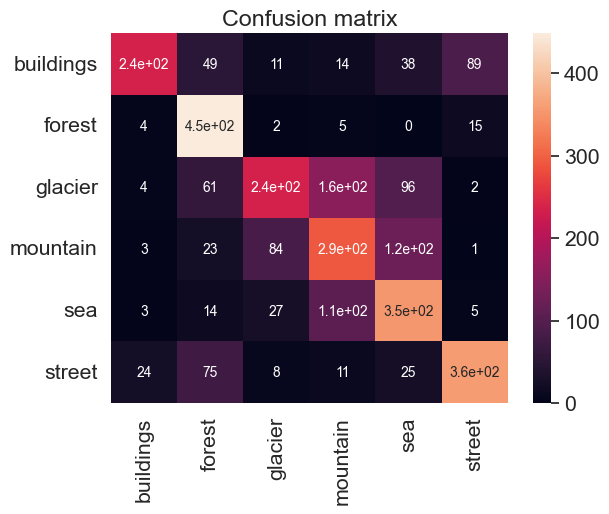

In [19]:
CM = metrics.confusion_matrix(y_test, y_pred)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=category_label, 
           yticklabels=category_label, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

### 6. Visualization

#### Predict the category classification for some random image

In [22]:
def category_predict(img_path):
    image = cv2.imread(img_path)
    ip_image = Image.open(img_path)
    image = cv2.resize(image,(150,150))
    prd_image_data = extract_image_data(img_path)
    category_predicted = lsvc.predict(prd_image_data.reshape(1, -1))[0]
    fig, ax = plt.subplots(1, 2, figsize=(12, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
    ax[0].imshow(ip_image)
    ax[0].set_title('input image')

    ax[1].imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
    ax[1].set_title('category predicted :'+ category_label[category_predicted]);

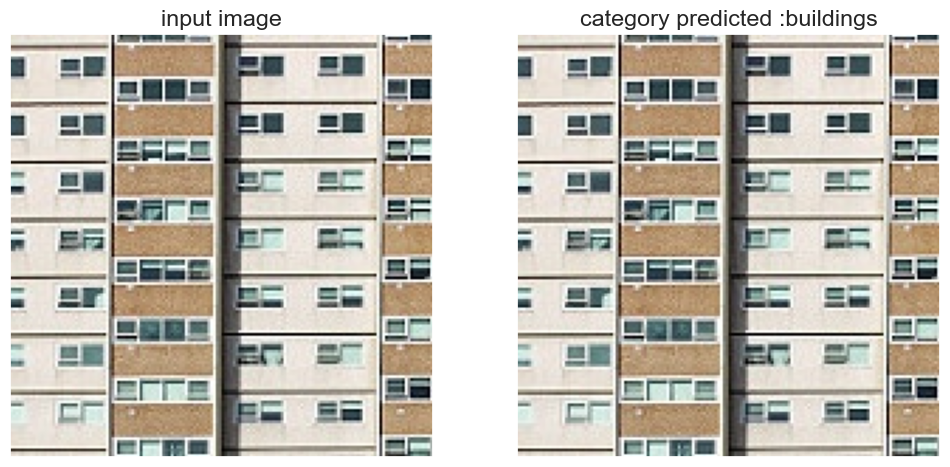

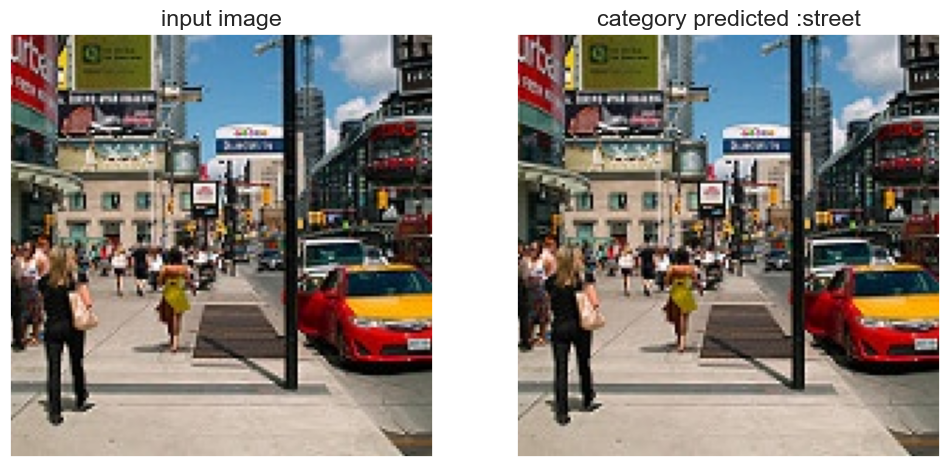

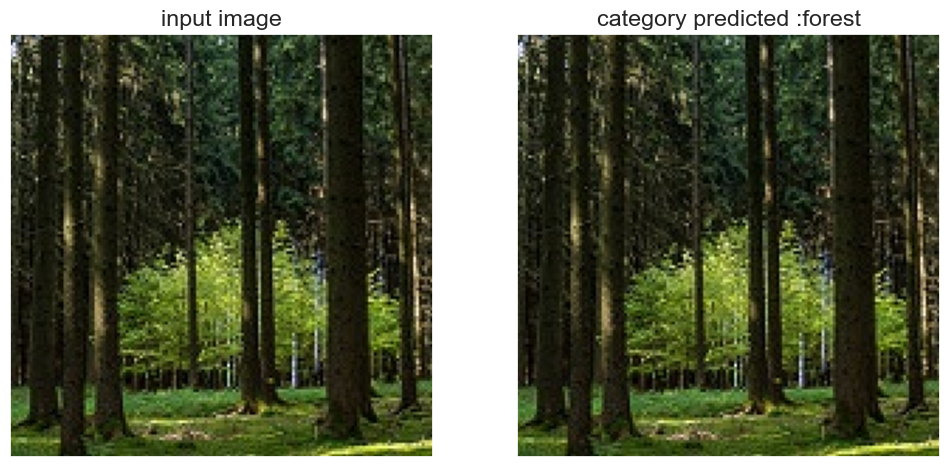

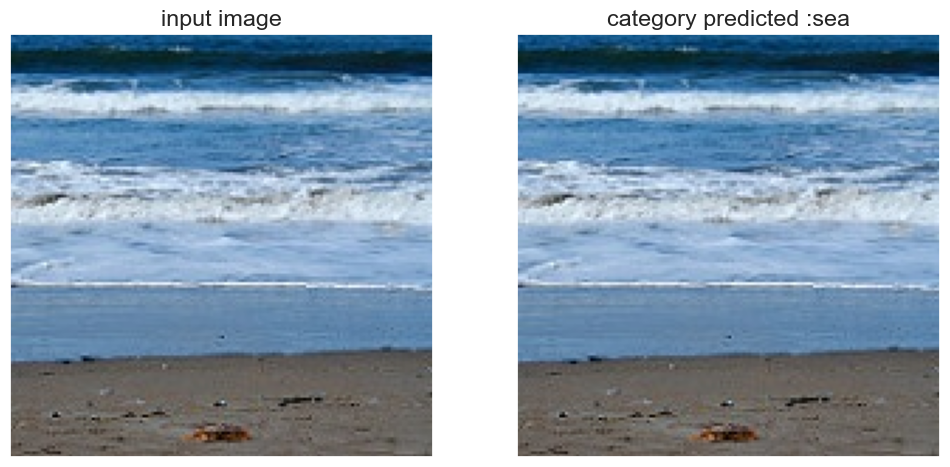

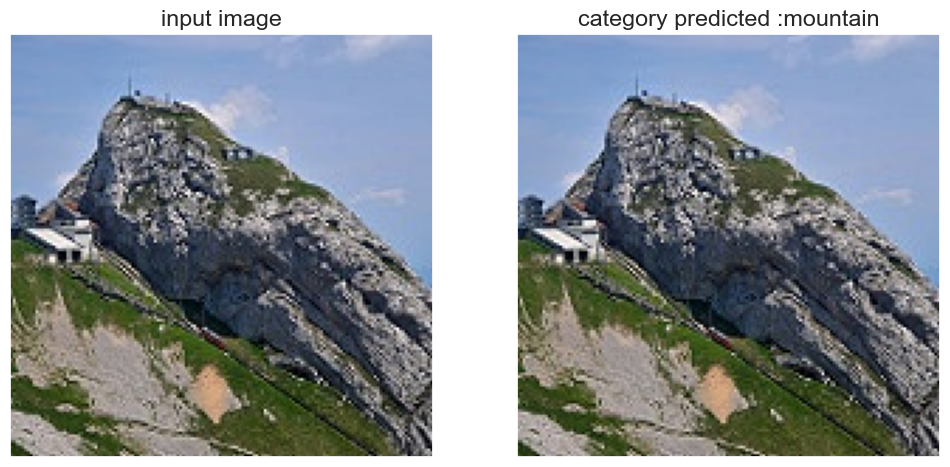

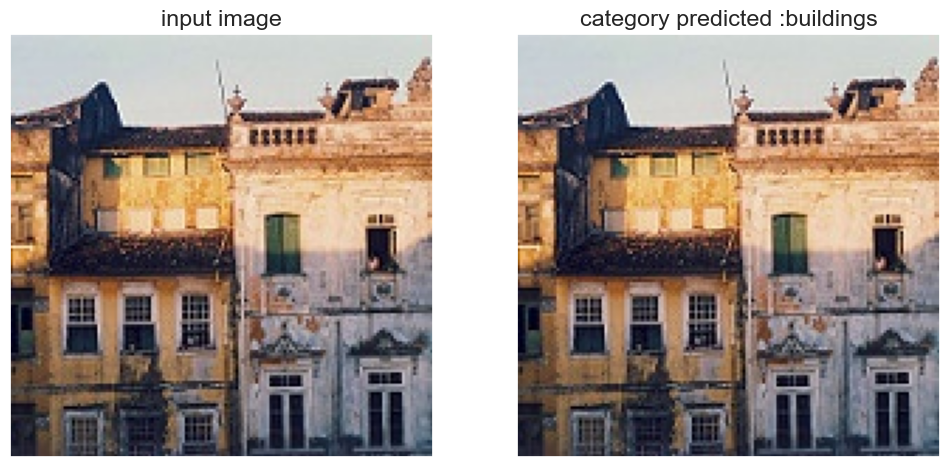

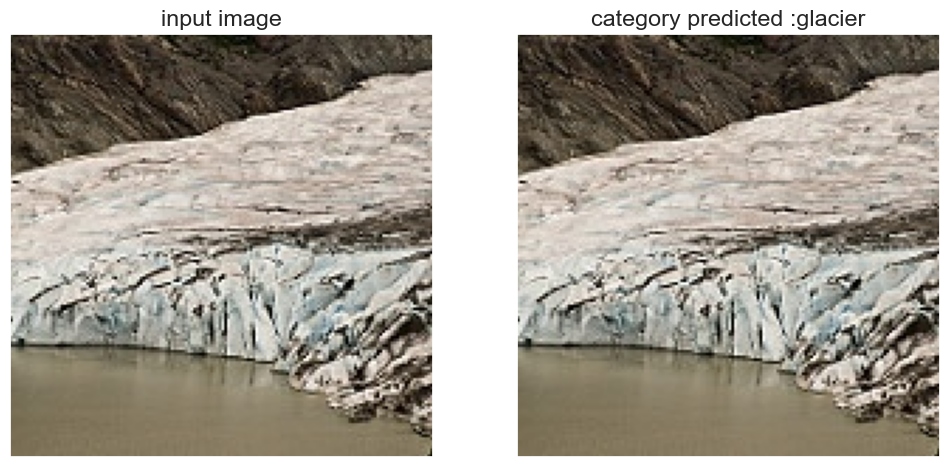

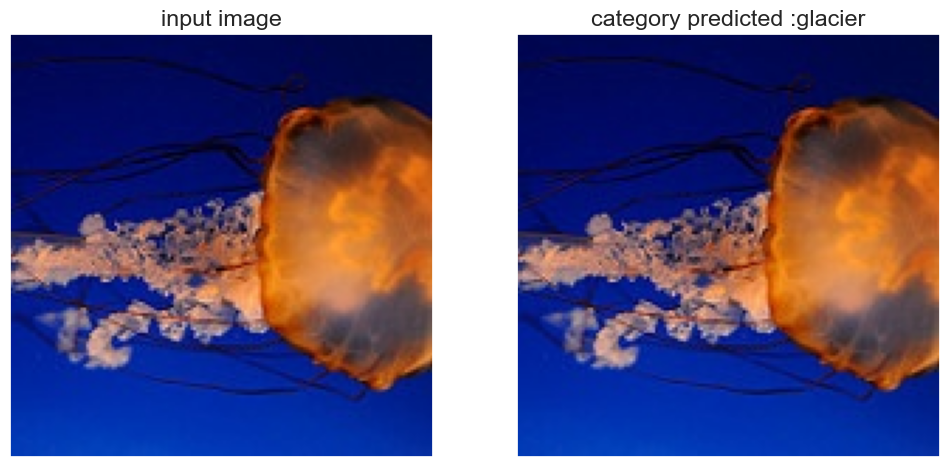

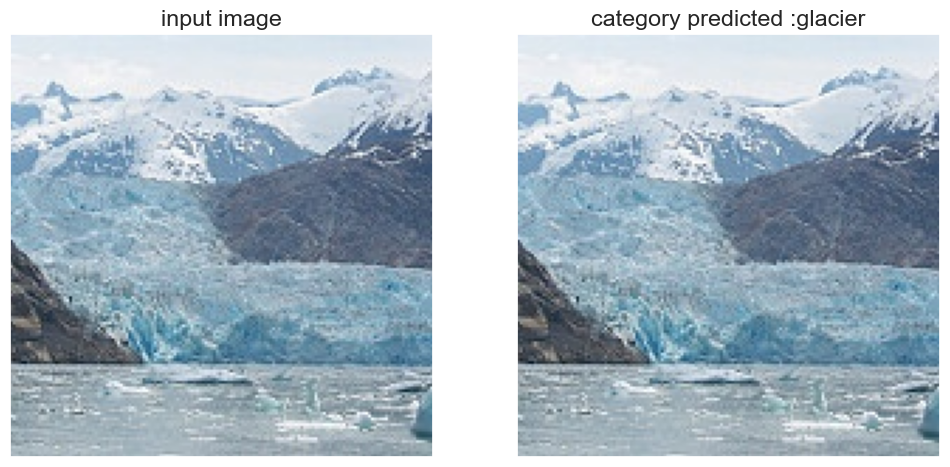

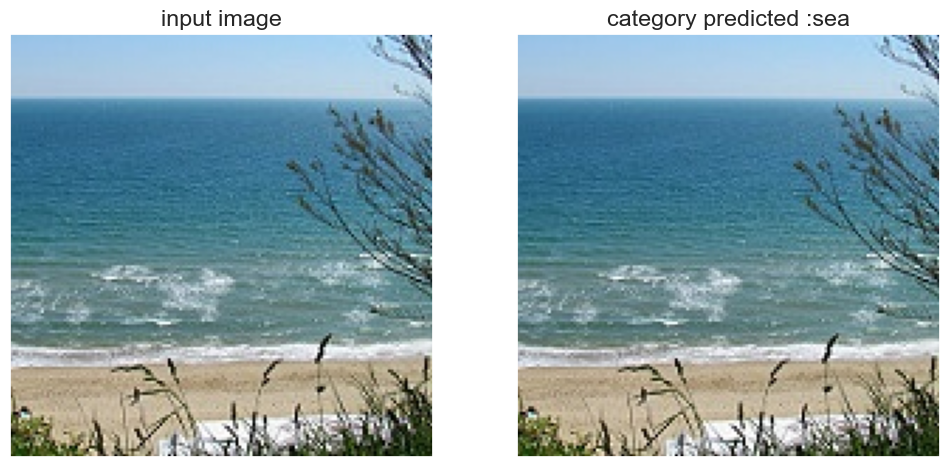

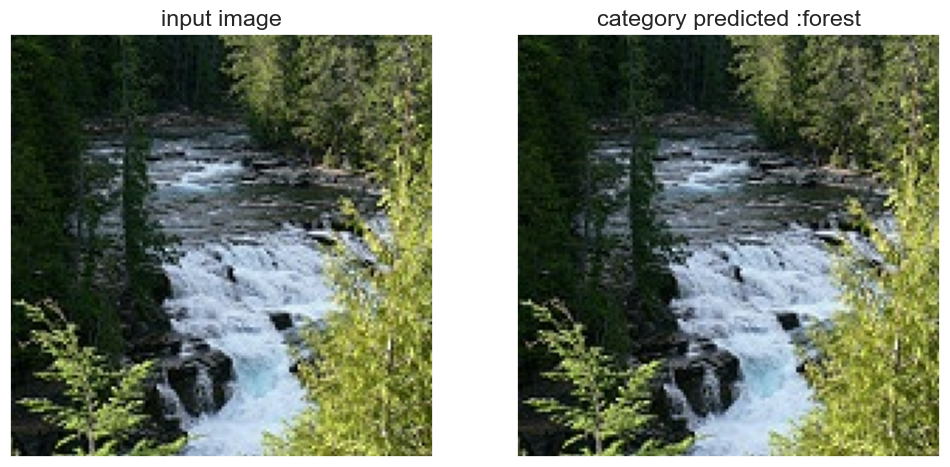

In [23]:
ip_img_folder = seg_pred_path
ip_img_files = ['222.jpg','121.jpg','88.jpg','398.jpg','839.jpg', '520.jpg', '38.jpg', '63.jpg', '101.jpg', '862.jpg', '890.jpg']
category_predicted = [category_predict(os.path.join(ip_img_folder,img_file))for img_file in ip_img_files]